In [1]:
# For local development enable python modules live reloading
%load_ext autoreload
%autoreload 2

# Generating gaits

The next step in developing the robot kinematics is to generate various gaits. First, lets familiarize ourselves with the concept of gaits. Gait is a coordinated sequence of movements of the robot legs and body to achieve smooth locomotion.

The gait cycle of a hexapod robot refers to the sequential movement of its six legs to achieve locomotion. It consists of two main phases for each leg:

 1. Stance Phase – The leg is in contact with the ground, providing support and propulsion as it moves backward relative to the body.
 2. Swing Phase – The leg lifts off the ground, moves forward, and prepares for the next stance phase.

To get an idea of the variance and complexity between gaits, Fig 1. shows four typical gaits. The six legs, right and left hind, middle and front, indicated as RH, RM, RF, LH, LM, and LF, at any one time are either on the ground pushing forward (supporting) shown in white, or in the air moving up to their next position (recovering) shown in black. [borrowed from hexapodrobot.weebly.com](https://hexapodrobot.weebly.com/the-legs.html)

<div>
<img src="hexapod_gaits.png" width="600"/>
</div>

Fig 1. Four typical hexapodal gaits, depicting each of the six legs as either supporting (white) or recovering (black). Image source: (Chen et al. 2012)

The two most common gaits for hexapods are the tripod gait and the ripple gait. The tripod gait is a simple gait where the robot legs move in two groups of three, lifting one group of three legs at a time. While the ripple gait is a more complex gait where the legs move in a wave-like motion, lifting one leg at a time.

## Tripod gait

The tripod gait is a simple gait where the robot legs move in two groups of three:
 - group A: left-front, right-middle, and left-back
 - group B: right-front, left-middle, and right-back.

while one group is in stance phase, the other group is in swing phase and cycle repeats.

Lets build the simplest tripod gait generator, it will generate offsets for each leg at a specific phase (0.0 to 1.0).

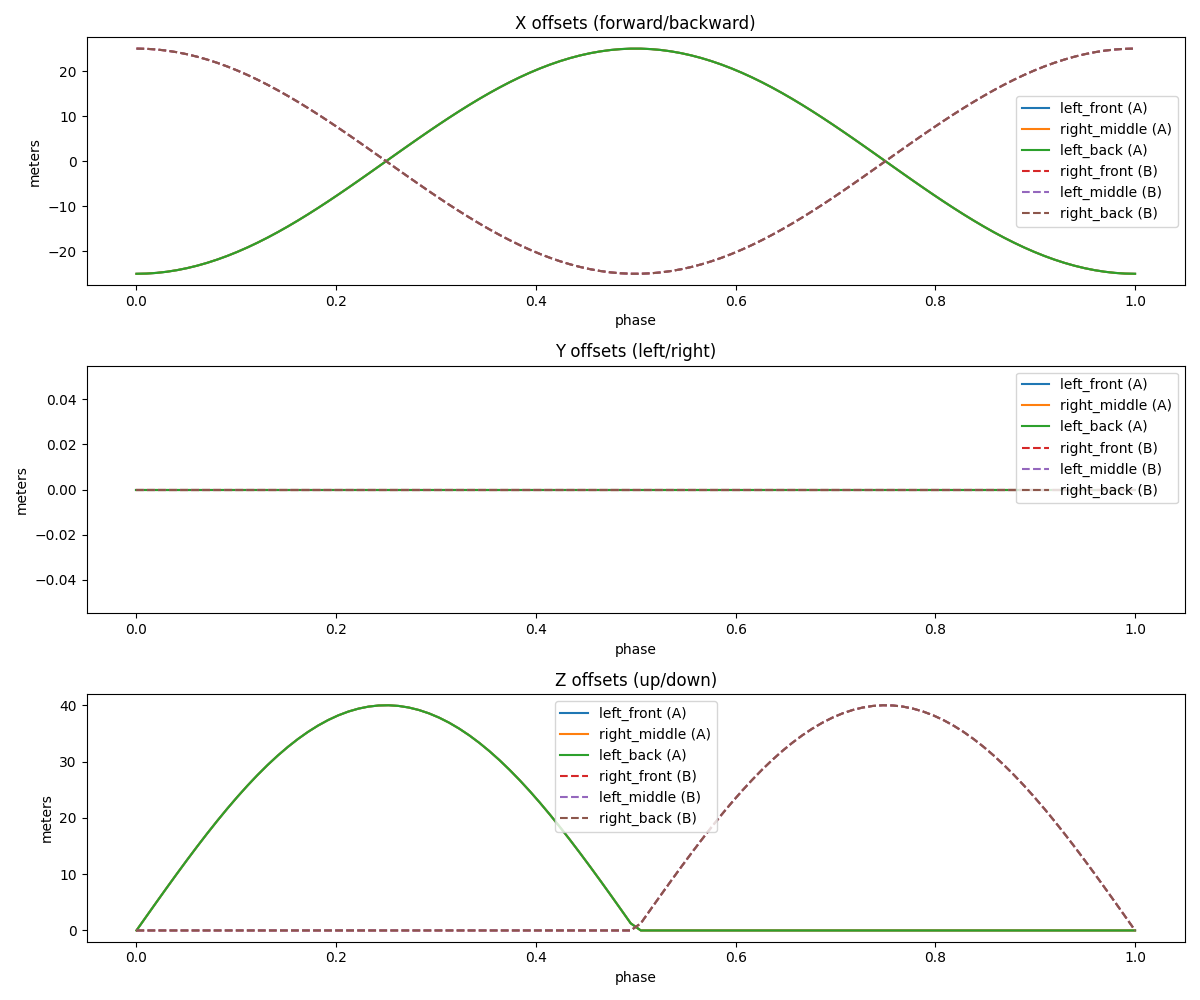

In [2]:
import numpy as np
from gait_generators import GaitGenerator
from point import Point3D


class TripodGaitGenerator(GaitGenerator):
    def __init__(
        self,
        step_length=50,  # Length of each step in meters
        step_height=40,  # Height of leg lift in meters
    ):
        """
        Tripod gait generator for hexapod robot.

        Generates leg tip offsets in right-hand coordinate system (x-forward, y-left, z-up).

        Parameters:
        -----------
            step_length: Length of each step in meters
            step_height: Height of leg lift in meters

        """
        # Store parameters as member fields
        self.step_length = step_length
        self.step_height = step_height

        # Define leg groups for tripod gait
        self.tripod_a = ['left_front', 'right_middle', 'left_back']
        self.tripod_b = ['right_front', 'left_middle', 'right_back']
        super().__init__(all_legs=self.tripod_a + self.tripod_b)

    def get_offsets_at_phase(self, phase) -> dict[str, Point3D]:
        """
        Get offsets for all legs at a specific phase (0.0 to 1.0).

        Parameters:
        -----------
            phase: Float between 0.0 and 1.0 representing the gait cycle progress

        Returns:
        --------
            Dictionary of leg positions with their corresponding offsets

        """
        # Generate offsets for each leg group
        offsets = {}

        # Tripod A legs
        a_offset = self._calculate_leg_offset(phase)
        for leg in self.tripod_a:
            offsets[leg] = a_offset

        # Tripod B legs (half cycle offset)
        b_offset = self._calculate_leg_offset(phase + 0.5)
        for leg in self.tripod_b:
            offsets[leg] = b_offset

        return offsets

    def get_offsets_at_phase_for_leg(self, leg, phase) -> Point3D:
        """
        Get offsets for all legs at a specific phase (0.0 to 1.0).

        Parameters:
        -----------
            phase: Float between 0.0 and 1.0 representing the gait cycle progress

        Returns:
        --------
            Offset for the specified leg

        """
        # Tripod B legs (half cycle offset)
        if leg in self.tripod_b:
            phase += 0.5

        return self._calculate_leg_offset(phase)

    def _calculate_leg_offset(self, phase):
        """Calculate offset for a single leg at phase."""
        # Ensure phase is between 0 and 1
        phase = phase % 1.0

        # Convert phase to angle (0 to 2π)
        t = phase * 2 * np.pi

        # X movement: forward during swing phase, backward during stance phase
        x_offset = -self.step_length / 2 * np.cos(t)

        # Z movement: up during swing phase, down during stance phase
        z_offset = 0
        if np.sin(t) > 0:  # Only lift during swing phase
            z_offset = self.step_height * np.sin(t)

        # Y offset is always zero for straight walking
        y_offset = 0

        return Point3D([x_offset, y_offset, z_offset])

    def _legend_for_leg(self, leg) -> str:
        if leg in self.tripod_a:
            return f'{leg} (A)'
        return f'{leg} (B)'

    def _line_style_for_leg(self, leg) -> str:
        if leg in self.tripod_a:
            return '-'
        return '--'


# Example usage
generator = TripodGaitGenerator()

# Visualize the continuous gait
%matplotlib widget
generator.visualize_continuous(steps=100)


interactive(children=(IntSlider(value=0, description='frame', max=180), Output()), _dom_classes=('widget-inter…

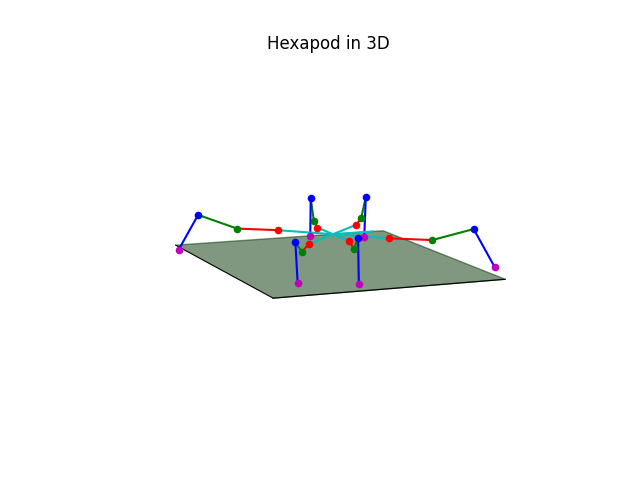

In [3]:
from matplotlib.animation import FuncAnimation
from ipywidgets import interact
from models import HexapodModel
from plotting import plot_hexapod, update_hexapod_plot, animate_plot_template


def animate_hexapod_gait(
    hexapod: HexapodModel,
    gaits_gen: GaitGenerator,
    interactive=False,
    skip=False,
    total_steps=60,
    interval=16,
    view_elev=10.0,
    view_azim=-112,
    repeat=3,
):
    def animate_impl():
        leg_tips = [leg.tibia_end.copy() for leg in hexapod.legs]

        def set_pose(step):
            step = step % total_steps  # handle repeats
            phase = step / total_steps  # interpolation phase
            for leg, leg_tip in zip(hexapod.legs, leg_tips):
                offsets = gaits_gen.get_offsets_at_phase_for_leg(leg.label, phase)
                leg.move_to(leg_tip + offsets)

        fig, ax, plot_data = plot_hexapod(hexapod)
        ax.view_init(elev=view_elev, azim=view_azim)

        def animate(frame=0):
            set_pose(frame)
            update_hexapod_plot(hexapod, plot_data)

        if interactive:
            return interact(animate, frame=(0, total_steps * repeat))
        return FuncAnimation(fig, animate, frames=total_steps * repeat, interval=interval)

    return animate_plot_template(animate_impl, interactive=interactive, skip=skip)


hexapod = HexapodModel()
hexapod.forward_kinematics(0, -25, 110)
generator = TripodGaitGenerator(step_length=120)

%matplotlib widget
anim = animate_hexapod_gait(hexapod, generator, interactive=True, skip=False)


This gives a nice forward locomotive gait. However some changes are needed to the generated gait. Right now it starts with legs on the ground, but with maxed out X offsets. To mitigate this we need to introduce a transition stage that will take legs from whatever position they are in to the starting position.

A good starting point for the transition is a 0.25 phase mark where all legs have zero offsets in X axis, however group A is lifted up. In order to start from all the legs on the ground we need to compress Z phase to quarter of the original cycle.

So here is the plan for transition stage: 
 1. It runs for 0.25 of the phase
 2. We start with X cycle at 0.25 
 3. We start Z cycle 0, but compress first 0.5 of it to 0.25. 
 4. At 0.5 both cycles sync up and cycle continues till 1.0
 5. Then we start the full cycle.

Transition out of gait is similar, but starts at 0 and ends at 0.25 or X and Z cycles is compressed to 0.25

interactive(children=(IntSlider(value=0, description='frame', max=180), Output()), _dom_classes=('widget-inter…

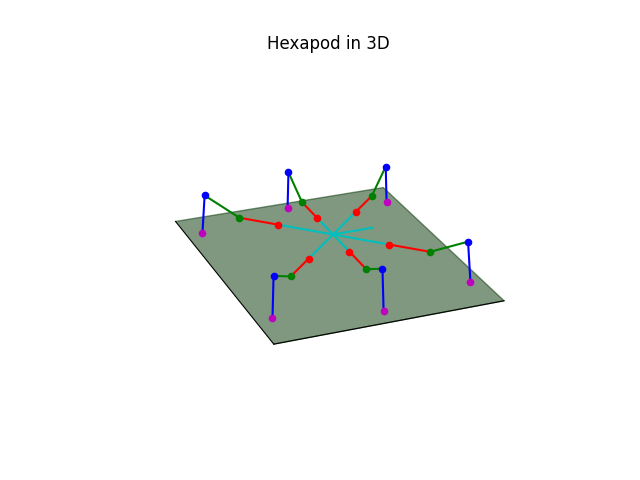

In [4]:

def animate_hexapod_gait(
    hexapod: HexapodModel,
    gaits_gen: GaitGenerator,
    interactive=False,
    skip=False,
    total_steps=60,
    interval=16,
    view_elev=7.0,
    view_azim=-112,
    repeat=2,
):
    transition_time_in = 0.75
    transition_steps_in = int(total_steps * transition_time_in)
    transition_steps_intro = int(total_steps * 0.25)
    transition_steps_rest = int(transition_steps_in - transition_steps_intro)

    phase_in_x_steps = np.concatenate((np.linspace(0.25, 0.5, transition_steps_intro), np.linspace(0.5, 1., transition_steps_rest)))
    phase_in_z_steps = np.concatenate((np.linspace(0.0, 0.5, transition_steps_intro), np.linspace(0.5, 1., transition_steps_rest)))

    transition_time_out = 0.25
    transition_steps_out = int(total_steps * transition_time_out)
    phase_out_x_steps = np.linspace(0.0, 0.25, transition_steps_out)
    phase_out_z_steps = np.linspace(0.0, 0.5, transition_steps_out)

    transition_steps_end = total_steps * repeat + transition_steps_in

    total_frames = total_steps * repeat + transition_steps_in + transition_steps_out

    def animate_impl():
        leg_tips = [leg.tibia_end.copy() for leg in hexapod.legs]


        def set_pose(step):
            if step < transition_steps_in:
                phase_x = phase_in_x_steps[step]
                phase_z = phase_in_z_steps[step]

                offsets = {}
                for leg in hexapod.legs:
                    off = gaits_gen.get_offsets_at_phase_for_leg(leg.label, phase_x)
                    offsets[leg.label] = Point3D([off.x, 0, 0])

                for leg in hexapod.legs:
                    off = gaits_gen.get_offsets_at_phase_for_leg(leg.label, phase_z)
                    offsets[leg.label] += Point3D([0, 0, off.z])

                for leg, leg_tip in zip(hexapod.legs, leg_tips):
                    leg.move_to(leg_tip + offsets[leg.label])
            elif step < transition_steps_end:
                step = step - transition_steps_in
                step = step % total_steps # handle repeats
                phase = step / total_steps # interpolation phase
                for leg, leg_tip in zip(hexapod.legs, leg_tips):
                    offsets = gaits_gen.get_offsets_at_phase_for_leg(leg.label, phase)
                    leg.move_to(leg_tip + offsets)

            else:
                end_step = (step - transition_steps_end)
                phase_x = phase_out_x_steps[end_step]
                phase_z = phase_out_z_steps[end_step]

                offsets = {}
                for leg in hexapod.legs:
                    off = gaits_gen.get_offsets_at_phase_for_leg(leg.label, phase_x)
                    offsets[leg.label] = Point3D([off.x, 0, 0])

                for leg in hexapod.legs:
                    off = gaits_gen.get_offsets_at_phase_for_leg(leg.label, phase_z)
                    offsets[leg.label] += Point3D([0, 0, off.z])

                for leg, leg_tip in zip(hexapod.legs, leg_tips):
                    leg.move_to(leg_tip + offsets[leg.label])

        fig, ax, plot_data = plot_hexapod(hexapod)
        ax.view_init(elev=view_elev, azim=view_azim)

        def animate(frame=0):
            set_pose(frame)
            update_hexapod_plot(hexapod, plot_data)

        if interactive:
            return interact(animate, frame=(0, total_frames))

        return FuncAnimation(fig, animate, frames=total_frames, interval=interval)

    return animate_plot_template(animate_impl, interactive=interactive, skip=skip)


hexapod = HexapodModel()
hexapod.forward_kinematics(0, -25, 110)
generator = TripodGaitGenerator(step_length=120)

%matplotlib widget
anim = animate_hexapod_gait(hexapod, generator, interactive=True, skip=False, view_elev=25)


This gives a nice forward locomotive gait. However it is forward only and there is no control over the direction of the movement. It is possible to move backwards by reversing the phase interpolation, but it would be nice to be able to control direction using the vector. This way this gait generator can be used with real robot and joystick control.

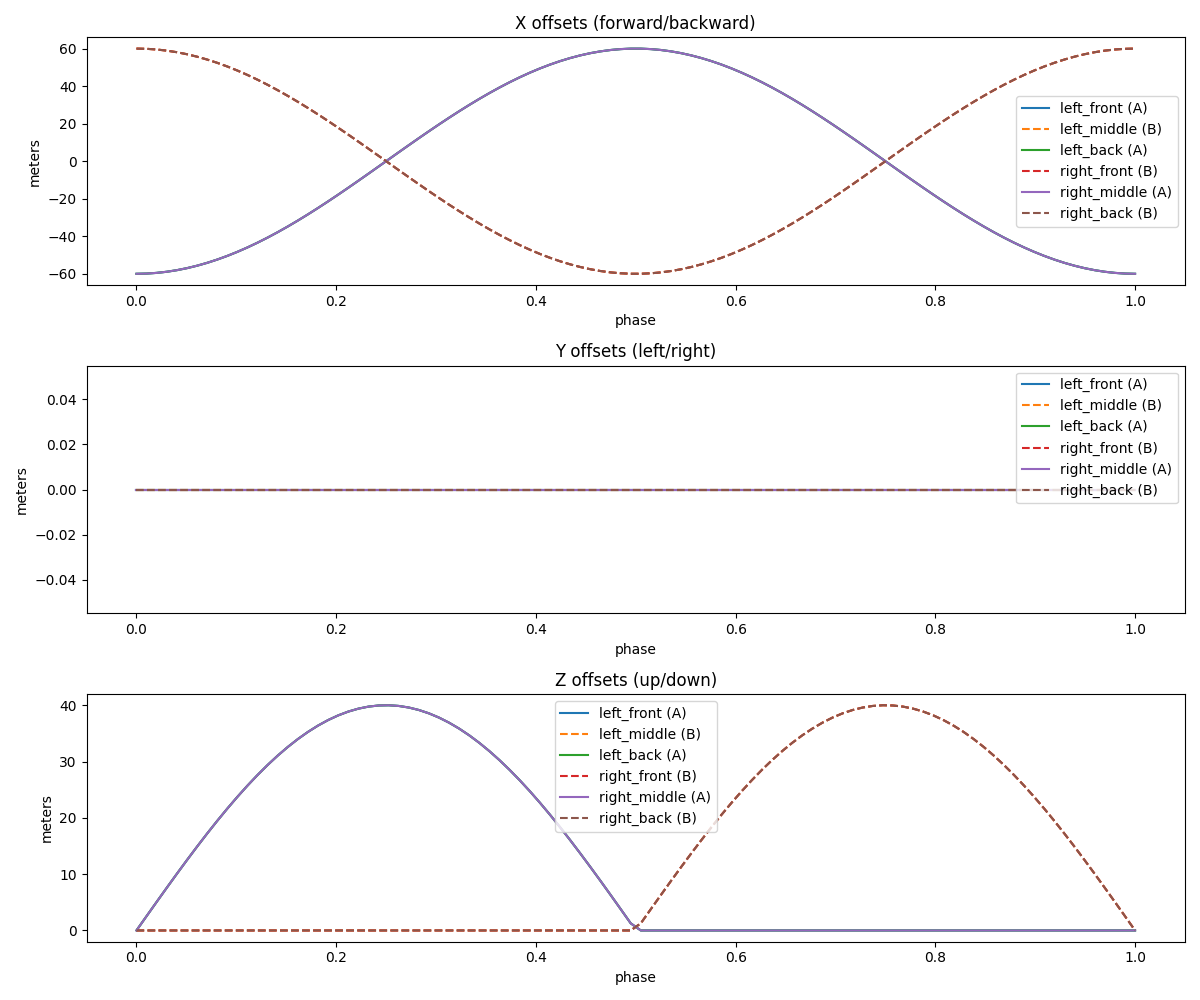

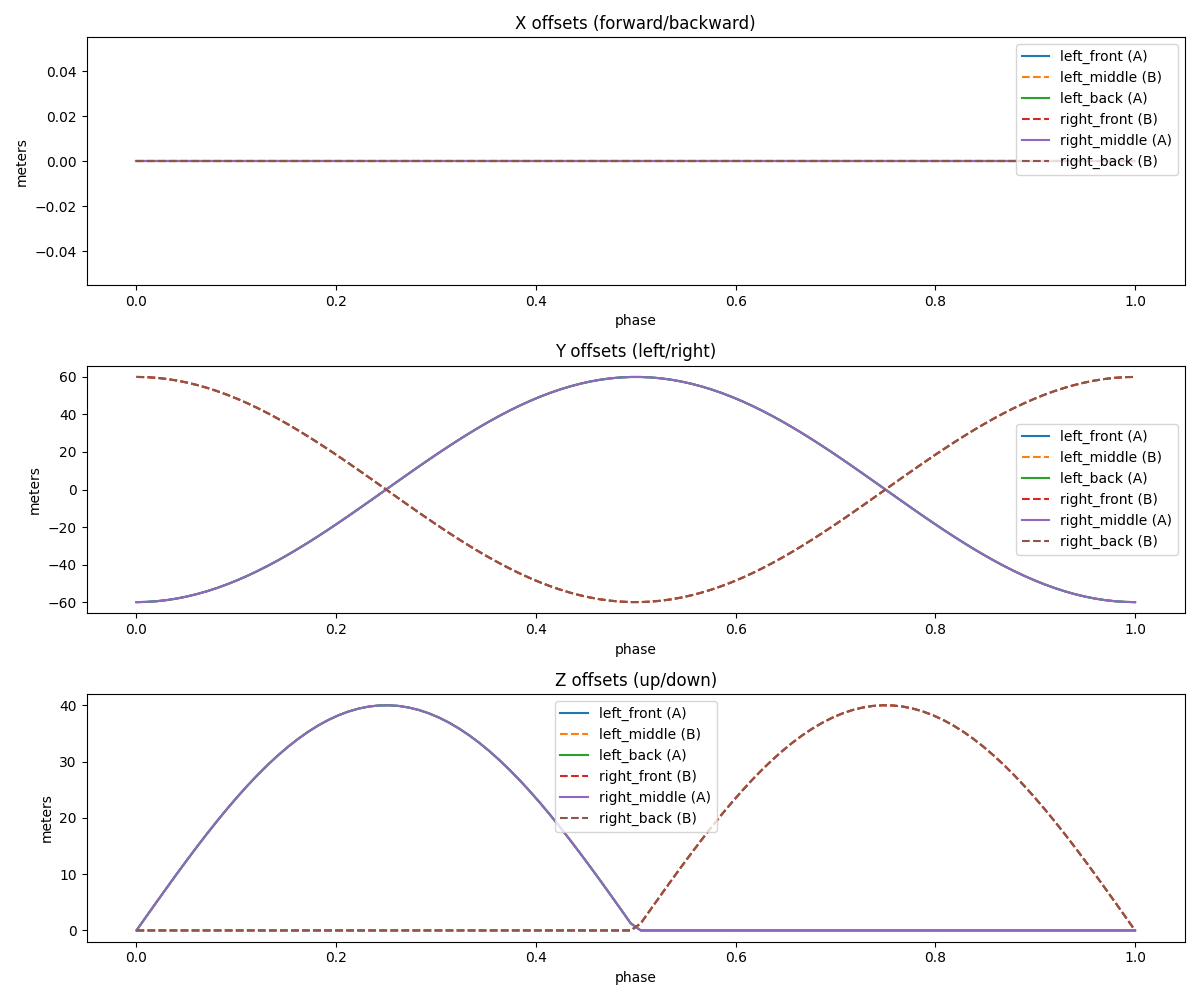

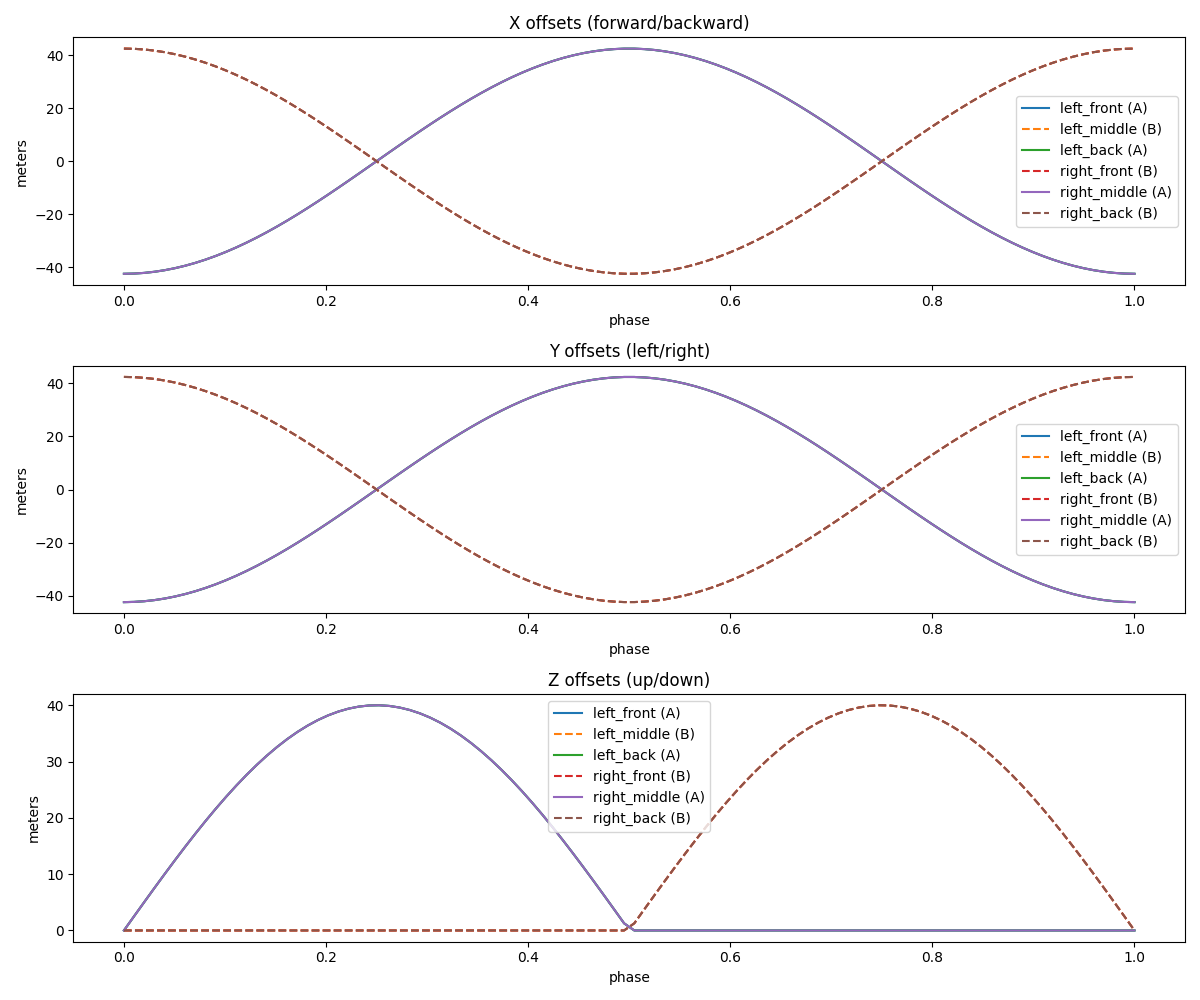

In [5]:
from transforms import Transform
from point import Point


class DirectionalGaitGenerator(GaitGenerator):
    """Gait generator decorator to allow steering in any direction."""

    def __init__(self, decorated: GaitGenerator):
        super().__init__()
        self.decorated = decorated


    def get_offsets_at_phase(self, phase, direction=Point(1, 0)) -> dict[str, Point3D]:
        tf = self.__make_transform(direction)
        offsets = self.decorated.get_offsets_at_phase(phase)
        return {leg: tf.apply_point(offsets[leg]) for leg in offsets}

    def get_offsets_at_phase_for_leg(self, leg, phase, direction=Point(1, 0)) -> Point3D:
        tf = self.__make_transform(direction)
        offsets = self.decorated.get_offsets_at_phase_for_leg(leg, phase)
        return tf.apply_point(offsets)

    @staticmethod
    def __make_transform(direction):
        # Normalize direction vector
        norm_direction = direction.numpy() / np.linalg.norm(direction.numpy())

        # Create rotation matrix to align direction with x-axis
        direction_transform = Transform.from_rotmatrix([
            [norm_direction[0], -norm_direction[1], 0],
            [norm_direction[1], norm_direction[0], 0],
            [0, 0, 1]
        ])

        return direction_transform

    def _legend_for_leg(self, leg) -> str:
        return self.decorated._legend_for_leg(leg)

    def _line_style_for_leg(self, leg) -> str:
        return self.decorated._line_style_for_leg(leg)


# Example usage
directional_tripod_gen = DirectionalGaitGenerator(TripodGaitGenerator(step_length=120))

directional_tripod_gen.visualize_continuous(direction=Point(1, 0))
directional_tripod_gen.visualize_continuous(direction=Point(0, 1))
directional_tripod_gen.visualize_continuous(direction=Point(1, 1))


Adding a direction vector did the trick, at least charts look good. Let's see it on the hexapod.

interactive(children=(IntSlider(value=0, description='frame', max=300), IntSlider(value=0, description='direct…

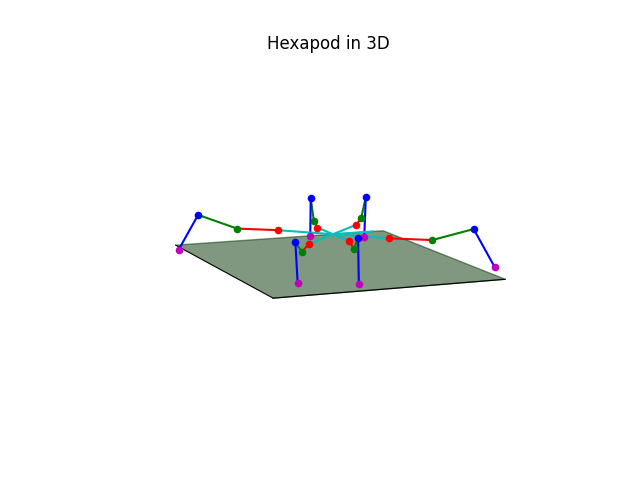

In [6]:
from functools import partial

def animate_hexapod_gait_with_direction(
    hexapod: HexapodModel,
    gaits_gen: GaitGenerator,
    interactive=False,
    skip=False,
    total_steps=60,
    interval=16,
    view_elev=10.0,
    view_azim=-112,
    repeat=5,
):
    def animate_impl():
        leg_tips = [leg.tibia_end.copy() for leg in hexapod.legs]

        def set_pose(step, direction):
            step = step % total_steps  # handle repeats
            phase = step / total_steps  # interpolation phase
            for leg, leg_tip in zip(hexapod.legs, leg_tips):
                offsets = gaits_gen.get_offsets_at_phase_for_leg(
                    leg.label, phase, direction=direction
                )
                leg.move_to(leg_tip + offsets)

        fig, ax, plot_data = plot_hexapod(hexapod)
        ax.view_init(elev=view_elev, azim=view_azim)

        def animate(frame=0, direction_degrees=0):
            if direction_degrees == -1000:
                direction_degrees = (frame / (total_steps * repeat)) * 360
            direction = Point(1, 0).rotate(np.radians(direction_degrees))
            set_pose(frame, direction)
            update_hexapod_plot(hexapod, plot_data)
            if interactive:
                fig.canvas.draw_idle()

        if interactive:
            return interact(animate, direction_degrees=(-180, 180, 1), frame=(0, total_steps * repeat))

        return FuncAnimation(fig, partial(animate, direction_degrees=-1000), frames=total_steps * repeat, interval=interval)

    return animate_plot_template(animate_impl, interactive=interactive, skip=skip)


hexapod = HexapodModel()
hexapod.forward_kinematics(0, -25, 110)

%matplotlib widget
anim = animate_hexapod_gait_with_direction(hexapod, directional_tripod_gen, interactive=True, skip=False)
